In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import pydicom

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



/usr/local/anaconda3/envs/autosegmentation/lib/python3.9/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
def load_scan():
    data_path = "/Users/salvatoreesposito/Downloads/datasets/manifest-1557326747206/LCTSC/LCTSC-Test-S1-102/11-04-2003-RTRCCTTHORAX8FHigh Adult-20444/0.000000-CT114545RespCT  3.0  B30f  50 Ex-81163"
    slices=[pydicom.dcmread(data_path + '/'+s, force=True)for s in os.listdir(data_path)]
    # slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [3]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan()
imgs = get_pixels_hu(patient)

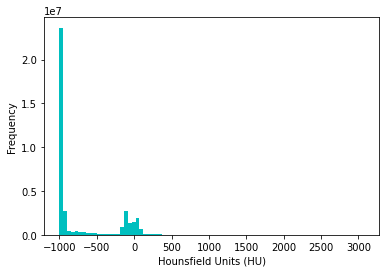

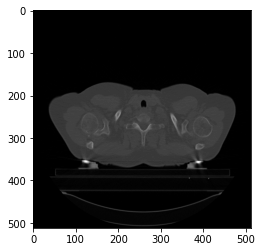

<Figure size 432x288 with 0 Axes>

In [4]:
first_patient = load_scan()
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()
plt.savefig("test_rasterization.pdf", dpi=300)
# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()
plt.savefig("test_scan.pdf", dpi=300)

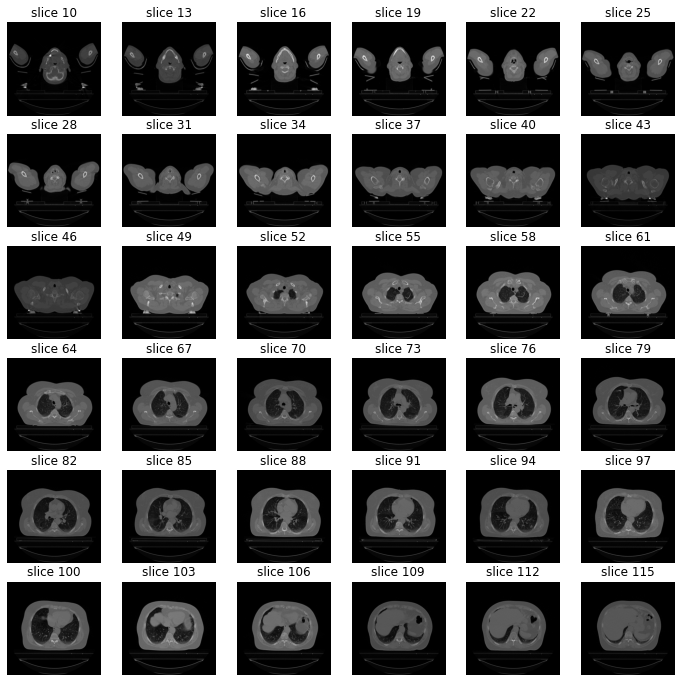

In [5]:
id = 0
output_path = working_path = "/Users/salvatoreesposito/Downloads/"
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.savefig('foo.png')
    plt.show()
sample_stack(imgs_to_process)

In [26]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [27]:
print ("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print ("Shape after resampling\t", imgs_after_resamp.shape)


Shape before resampling	 (148, 512, 512)


In [134]:

def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

# def plotly_3d(verts, faces):
#     x,y,z = zip(*verts) 
    
#     print ("Drawing")
    
#     # Make the colormap single color since the axes are positional not intensity. 
# #    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
#     colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
#     fig = FF.create_trisurf(x=x,
#                         y=y, 
#                         z=z, 
#                         plot_edges=False,
#                         colormap=colormap,
#                         simplices=faces,
#                         backgroundcolor='rgb(64, 64, 64)',
#                         title="Interactive Visualization")
#     iplot(fig)


In [135]:
def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

In [136]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

Transposing surface
Calculating surface
Drawing


KeyboardInterrupt: 

In [ ]:
v, f = make_mesh(imgs_after_resamp, 350, 2)
plotly_3d(v, f)